In [1]:
import os
import math
import numpy as np

# Battery Dimer Analysis

This notebook is a short and schematic summary of the analysis performed for my MRS Advances paper, which discusses and compares the formation of oxygen dimers in Li$_{0.5}$MnO$_3$ and Li$_{0.5}$MnO$_3$.

## Oxygen Oxidation

To start our analysis, we take a look at the magnetic moments of the various elements in both structures. We want to compare the magnetic moments on the Mn, Ir and O atoms for the discharged and 75% charged structure. As we have relaxed all bulk structures with HSE06, we can use these results to discuss the change in oxidation state, by analyzing the change in magnetic moments. Here's how we can extract the magnetic moments from the Outcar using pymatgen's vasp I/O:



In [2]:
from pymatgen.io.vasp.outputs import Outcar

out = Outcar("./data/oxidation/Li2MnO3_hse_OUTCAR")
out.magnetization

({'d': 0.0, 'p': -0.0, 's': -0.0, 'tot': -0.0},
 {'d': 0.0, 'p': -0.0, 's': -0.0, 'tot': -0.0},
 {'d': 0.0, 'p': 0.0, 's': 0.0, 'tot': 0.0},
 {'d': 0.0, 'p': -0.0, 's': -0.0, 'tot': -0.0},
 {'d': 2.973, 'p': 0.029, 's': 0.013, 'tot': 3.014},
 {'d': -2.973, 'p': -0.029, 's': -0.013, 'tot': -3.014},
 {'d': 0.0, 'p': 0.001, 's': 0.0, 'tot': 0.001},
 {'d': 0.0, 'p': -0.001, 's': -0.0, 'tot': -0.001},
 {'d': 0.0, 'p': -0.002, 's': -0.0, 'tot': -0.002},
 {'d': 0.0, 'p': -0.001, 's': -0.0, 'tot': -0.001},
 {'d': 0.0, 'p': 0.002, 's': 0.0, 'tot': 0.002},
 {'d': 0.0, 'p': 0.001, 's': 0.0, 'tot': 0.001})

We can see that the output of the magnetization is given in terms of the various orbitals and the total for each atom in the structure. Let's extract the total for each element and average the absolute value of the magnetic moment:

In [3]:
total_magnetization = [atom['tot'] for atom in out.magnetization]
li2mno3_magmom = dict()
li2mno3_magmom["Mn"] = (sum([abs(mag) for mag in total_magnetization[4:6]]))/2
li2mno3_magmom["O"] = (sum([abs(mag) for mag in total_magnetization[6:]]))/6
print("Li2MnO3: magnetization on Mn = " + str(li2mno3_magmom["Mn"]))
print("Li2MnO3: magnetization on O = " + str(round(li2mno3_magmom["O"], 3)))

Li2MnO3: magnetization on Mn = 3.014
Li2MnO3: magnetization on O = 0.001


This could be done a lot better, really. I could write a little script to just get this automatically. But it'll do for now, considering we have a paper to finish. Let's continue with the other structures:

In [4]:
total_abs_magnetization = [abs(atom['tot']) for atom in Outcar("./data/oxidation/Li0.5MnO3_hse_OUTCAR").magnetization]
li05mno3_magmom = dict()
li05mno3_magmom["Mn"] = (sum(total_abs_magnetization[1:3]))/2
li05mno3_magmom["O"] = (sum(total_abs_magnetization[3:]))/6
print("Li0.5MnO3: magnetization on Mn = " + str(li05mno3_magmom["Mn"]))
print("Li0.5MnO3: magnetization on O = " + str(round(li05mno3_magmom["O"], 3)))

Li0.5MnO3: magnetization on Mn = 2.963
Li0.5MnO3: magnetization on O = 0.45


In [5]:
total_abs_magnetization = [abs(atom['tot']) for atom in Outcar("./data/oxidation/Li2IrO3_hse_OUTCAR").magnetization]
li2iro3_magmom = dict()
li2iro3_magmom["Ir"] = (sum(total_abs_magnetization[4:6]))/2
li2iro3_magmom["O"] = (sum(total_abs_magnetization[6:]))/6
print("Li2IrO3: magnetization on Ir = " + str(li2iro3_magmom["Ir"]))
print("Li2IrO3: magnetization on O = " + str(round(li2iro3_magmom["O"], 3)))

Li2IrO3: magnetization on Ir = 0.738
Li2IrO3: magnetization on O = 0.076


In [6]:
total_abs_magnetization = [abs(atom['tot']) for atom in Outcar("./data/oxidation/Li0.5IrO3_hse_OUTCAR").magnetization]
li05iro3_magmom = dict()
li05iro3_magmom["Ir"] = (sum(total_abs_magnetization[1:3]))/2
li05iro3_magmom["O"] = (sum(total_abs_magnetization[3:]))/6
print("Li0.5MnO3: magnetization on Ir = " + str(li05iro3_magmom["Ir"]))
print("Li0.5MnO3: magnetization on O = " + str(round(li05iro3_magmom["O"], 3)))

Li0.5MnO3: magnetization on Ir = 1.165
Li0.5MnO3: magnetization on O = 0.371


This was probably not the most efficient way of doing this. This task could have been more easily performed by just copying the values into MATLAB and making the figure. But it could serve as a tutorial in the future.

## Oxygen Lattice framework distortion

Next we'll take a look at the distances between the oxygen atoms. One way to do this would be to open the structure files in VESTA, and then click a lot. But clicking is for people that don't know Python. We've already written a script that uses the voronoi decomposition of the structure in order to find the neighbors, and then reconstruct the potential oxygen dimers around a specific site. So let's do that. Starting by loading the fully discharged and 75% charged structures of Li$_2$MnO$_3$:

In [7]:
from pybat.core import Cathode, LiRichCathode

li2mno3_cat = LiRichCathode.from_file("./data/oxygen_distortion/o3-li2mno3.json")
li05mno3_cat = LiRichCathode.from_file("./data/oxygen_distortion/o1-li0.5mno3.json")
print(li2mno3_cat)
print()
print(li05mno3_cat)

Full Formula (Li4 Mn2 O6)
Reduced Formula: Li2MnO3
abc   :   4.979788   4.979788   5.073692
angles:  80.383533  80.383531 119.882393
Sites (12)
  #    #VESTA  SP            a          b          c    magmom
---  --------  ----  ---------  ---------  ---------  --------
  0         1  Li     0.5        0.5        0            0
  1         2  Li    -0         -0          0.5          0
  2         3  Li     0.661809   0.338191   0.5          0
  3         4  Li     0.338191   0.661809   0.5         -0
  4         5  Mn     0.167033   0.832967   0            3.041
  5         6  Mn     0.832967   0.167033  -0           -3.041
  6         7  O      0.781049   0.781049   0.228685    -0
  7         8  O      0.218951   0.218951   0.771315     0
  8         9  O      0.066414   0.42414    0.224551    -0.002
  9        10  O      0.57586    0.933586   0.775449    -0.002
 10        11  O      0.933586   0.57586    0.775449     0.002
 11        12  O      0.42414    0.066414   0.224551     0.00

These have been fully optimized and re-optimized in order to avoid [Pulay stresses.](http://cms.mpi.univie.ac.at/vasp/guide/node161.html) (Notice how you can add links to the markdown. Easy and useful.) Next, we use some Python magic to find all of the distances for both structures and put then in a nice and sorted `List`:

In [8]:
li2mno3_distances = [li2mno3_cat.distance_matrix[indices] for indices in li2mno3_cat.find_oxygen_dimers(4)]
li2mno3_distances.sort(); li2mno3_distances

[2.574242106443846,
 2.574242123892187,
 2.6030370413569446,
 2.7745158036884083,
 2.7745158036884083,
 2.7745158226175515,
 2.774515822617552,
 2.7795183447383067,
 2.7795183447383067,
 2.790746672654144,
 2.8078407335807345,
 2.807840789092908]

In [9]:
li05mno3_distances = [li05mno3_cat.distance_matrix[indices] for indices in li05mno3_cat.find_oxygen_dimers(4)]
li05mno3_distances.sort(); li05mno3_distances

[2.4765280123668454,
 2.47653474005797,
 2.4765773655518086,
 2.6979991457600354,
 2.6980480180966064,
 2.698055437620388,
 2.7886016981628314,
 2.788601698162832,
 2.78861561199193,
 2.788615611991931,
 2.7886205882155957,
 2.788620588215596]

We can immediately see that the discharged structure has a long and short distance (within a certain margin of error). For the charged structure, the short distance has shortened by about 0.1 angstrom (Oh, yeah, the distances are expressed in angstrom, FYI). Three of the long distances have shortened as well, and I have a suspicion that it are the ones that are slightly longer in the original structure. Let's check this by comparing the distances before I foolishly sorted them:

In [10]:
li2mno3_distances = [li2mno3_cat.distance_matrix[indices] for indices in li2mno3_cat.find_oxygen_dimers(4)]
li05mno3_distances = [li05mno3_cat.distance_matrix[indices] for indices in li05mno3_cat.find_oxygen_dimers(4)]
li2mno3_distances

[2.790746672654144,
 2.7745158036884083,
 2.7795183447383067,
 2.574242123892187,
 2.7745158226175515,
 2.6030370413569446,
 2.807840789092908,
 2.7745158036884083,
 2.574242106443846,
 2.7795183447383067,
 2.774515822617552,
 2.8078407335807345]

In [11]:
[dis1 - dis2 for dis1, dis2 in zip(li05mno3_distances, li2mno3_distances)]

[-0.002126084438548226,
 -0.0764677855918019,
 0.009083353424525153,
 -0.09771411152534171,
 -0.29793845706574285,
 0.09496210440309083,
 -0.01922517710097793,
 0.014099808303522643,
 0.21437848177175,
 -0.3029836046803367,
 0.014085875545279514,
 -0.10978529596034647]

Hmm, some of the distances increase! Either the `find_oxygen_dimers` method somehow does not find two lists that correspond for the two structures, or the distortion is more interesting than just a reduction in the distances for the oxygen pairs. That could be possible, and maybe dependent on the lithium configuration. Let's look into this later. For now we'll just mention that the shorter distances get shorter, whereas most of the longer ones stay the same, which leads to a deformation. The shorter distances getting shorter corresponds to the formation of dimers in the view of Artem's science article.

`Note: Maybe the oxygen pairs don't correspond, because of course the O3->O1 transformation changes the octaheders quite a bit. Might be worth looking into and discussing in the paper.`

## Li configuration analysis

In order to study partially charged structures, such as Li$_{0.5}$MnO$_3$ and Li$_{0.5}$IrO$_3$, a choice must be made for the Lithium configuration. Hence, it is important to investigate the optimal lithium configuration, by comparing the formation energies of the various lithium configurations. We will not add this discussion to the paper extensively though, as this has been investigated before. We'll just mention that our results correspond to the ones in the literature. Which is accurate. I might add the actual analysis later to show how we checked this. For now, you'll have to [trust me](https://media1.tenor.com/images/7d64c9003647a2e846eede7ffef1a63a/tenor.gif?itemid=5698466).

## Oxygen dimer analysis

Alright, we've convinced ourselves that the oxygen oxidated in both structures as we remove the lithium. We've also noted that the oxygen framework is distored slightly by this removal. However, what we are really interested in is to see whether this all leads to the formation of proper oxygen dimers, i.e. oxygen pairs which are bonded convalently, sharing electrons and in such a way replenishing their p-orbitals to remove their magnetic moments. To investigate the formation of dimers, we need to check which pairs of oxygen that are connected in the octahedral environment of a cation site can form a dimer. The basic step of seeing whether such a dimer can be formed, is just pushing the oxygen pair closer together, and optimizing the structure. If the new structure is optimized and forms a stable dimer, we compare the total energy with that of the original pre-dimer structure. If the energy lower, there is a thermodynamic argument to be made that the structure wants to form such dimers. The next question is whether this is kinetically possible, but we'll answer that later.

### Symmetry analysis
Of course, we need to study the dimer formation in a sufficiently large supercell of the original structure, or we'll be investigating more of a phase transformation than the formation of a defect, which is how we interpret the local formation of a dimer. We don't want to just pick a few oxygen pairs in the structure, however, and check whether they form a dimer. Instead, we want to be complete, i.e. study all non-equivalent oxygen pairs with the potential to form a dimer. What we've done for the structures is start with an analysis of the symmetry of the structure in order to find a list of the inequivalent dimers. The dimers themselves are found by analysing the neighbours around each site, using the `pymatgen.chemenv` module. Let's start by loading our in-house developed `pybat` package and loading the 2x2x2 supercell O1-Li$_{0.5}$MnO$_3$ structure with the 1a cation configuration for the Li atoms:

In [12]:
import os
import pybat.core as pb

structure_filename = os.path.abspath("./data/dimer_symmetry/O1-1a_Li0.5MnO3_222.json")

cat = pb.LiRichCathode.from_file(structure_filename)

Note that this strucure has been constructed from the optimized primitive unit cell, and optimized in turn. Let's have a look at our final cathode structure:

In [13]:
print(cat)

Full Formula (Li8 Mn16 O48)
Reduced Formula: LiMn2O6
abc   :   9.996316   9.996316   8.225567
angles:  90.000000  90.000000 120.000000
Sites (96)
  #  #VESTA    SP           a         b          c    magmom
---  --------  ----  --------  --------  ---------  --------
  0  1         Li    0         0         -0            0.003
  1  2         Li    0         0          0.5          0.003
  2  3         Li    0         0.5       -0            0.003
  3  4         Li    0         0.5        0.5          0.003
  4  5         Li    0.5       0         -0            0.003
  5  6         Li    0.5       0          0.5          0.003
  6  7         Li    0.5       0.5       -0            0.003
  7  8         Li    0.5       0.5        0.5          0.003
  8  -         Vac   1         0          0.25         0
  9  -         Vac   0         0          0.75         0
 10  -         Vac   0         0.5        0.25         0
 11  -         Vac   0         0.5        0.75         0
 12  -         V

Note that the structure also keeps track of the vacancies. These are kept in the structure in order for the Voronoi decomposition of the `chemenv` package to keep functioning properly, as well as making it easier to define a migration of the transition metals. The #VESTA column in the printed string is just to figure out the corresponding atom when opening the corresponding POSCAR or .cif file in VESTA. Let's first take a look at how many potential dimers there are in the 2x2x2 unit cell of the structure:

In [14]:
len(cat.find_oxygen_dimers())

438

This takes a little longer, because setting up the Voronoi decomposition for the structure using the `pymatgen.analysis.chemenv` package takes some time. It would take quite some time to calculate the formation energy for all of these potential dimers. Fortunately, we've also developed a method for finding the inequivalent dimers in a structure:

In [15]:
cat.find_noneq_dimers()

[(64, 54), (64, 77), (54, 76), (81, 48), (81, 89), (88, 64)]

You can see that of all the dimers in the structure, there are only 6 inequivalent ones. This makes the analysis of the stability of the oxygen framework somewhat easier. I've built upon this method in combination with the `fireworks` package in order to set up a workflow that immediately calculates the formation energy for all the non-equivalent dimers. I won't be executing this here, as it sends these workflows to the pybat server on mLab (Soon to be Mongo DB Atlas.). 

The OUTCAR's of the scf calculation on the optimized structures are put in `data/dimer_thermo/`. I've only added the ones of the dimers for which the energy actually decreases. The full analysis will have to be done later.

Just as a clarification: The above dimers' indices for do not correspond to the ones that were chosen be the workflow script. That script actually finds the dimers that are the closest tot the center of the unit cell, for easy visualisation purposes. However, the dimer combinations that I actually have analyzed all have an equivalent dimer in the list above. To check this, here you can find the lists of equivalent dimers for the list on inequivalent dimers (if that makes sense to you).

In [16]:
dimer_lists = cat.list_noneq_dimers()

That probably took a while. It's most likely not the most efficient implementation, but it's fine for our purposes. To convince you that the dimers I analyze below correspond to one of the dimers in the list above, you can use the following little piece of code to find the dimer it corresponds to.

In [17]:
dimer_search = (80, 49)

for list in dimer_lists:
    if dimer_search in list:
        equivalent_dimer = list[0]
        print("Found requested dimer in list of " + str(equivalent_dimer))

# Let's check it
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
symmops = SpacegroupAnalyzer(cat).get_space_group_operations()
symmops.are_symmetrically_equivalent(
    [cat.sites[index] for index in dimer_search],
    [cat.sites[index] for index in equivalent_dimer]
)


Found requested dimer in list of (81, 48)


True

This should show one of the dimers in the above list, and say True. If it doesn't, please contact me, because then I really have to start writing some units tests.

### Thermodynamics

So let's take a look at the energies of the dimer structures and compare them with that of the original charged structure. First, we'll load the output data from the OUTCAR files of the SCF calculations, performed after the geometric optimizations:

In [18]:
out_original = Outcar("./data/dimer_thermo/O1-1a-Li0.5MnO3_222_OUTCAR")
out_48_92 = Outcar("./data/dimer_thermo/Li0.5MnO3_48_92_OUTCAR")
out_80_49 = Outcar("./data/dimer_thermo/Li0.5MnO3_80_49_OUTCAR")

Extracting the final energies from the outcar object is fairly easy. It simply has a final energy property:

In [19]:
out_original.final_energy

-442.49177984

So, let's use that to calculate the energy differences:

In [20]:
print("The energy difference for dimer 48-92 is: " 
      + str(round(out_48_92.final_energy - out_original.final_energy,3)) + " eV")
print("The energy difference for dimer 80-49 is: "
      + str(round(out_80_49.final_energy - out_original.final_energy, 3)) + " eV")

The energy difference for dimer 48-92 is: -0.083 eV
The energy difference for dimer 80-49 is: -0.553 eV


So, if everything worked out, this should say that both dimers have a lower energy than the original structure, i.e. a negative energy difference. That's pretty much all there is to analyzing the thermodynamics of the dimer formation. 

### Oxidation

However, let's also take a look at the oxidation states of the oxygen atoms in the final geometry. However, to actually check the corresponding indices, we need to use the Cathode object. So, let's load the `Cathode` of the 80-49 dimer structure:

In [21]:
cat_80_49 = Cathode.from_file("data/dimer_thermo/Li0.5MnO3_80_49.json")
print(cat_80_49)

Full Formula (Li8 Mn16 O48)
Reduced Formula: LiMn2O6
abc   :   9.996316   9.996316   8.225567
angles:  90.000004  90.000000 119.999998
Sites (96)
  #  #VESTA    SP           a         b         c    magmom
---  --------  ----  --------  --------  --------  --------
  0  1         Li    0.004931  0.004915  0.000383     0.003
  1  2         Li    0.989013  0.989044  0.506886     0.003
  2  3         Li    1.7e-05   0.500071  9e-06        0.003
  3  4         Li    0.998331  0.501484  0.499964     0.003
  4  5         Li    0.499983  0.999929  0.999991     0.003
  5  6         Li    0.501669  0.998516  0.500036     0.003
  6  7         Li    0.495069  0.495085  0.999617     0.003
  7  8         Li    0.510987  0.510956  0.493114     0.003
  8  -         Vac   1         0         0.25         0
  9  -         Vac   0         0         0.75         0
 10  -         Vac   0         0.5       0.25         0
 11  -         Vac   0         0.5       0.75         0
 12  -         Vac   0.5      

In [22]:
print("The total magnetic moment of oxygen(80) is: " + str(cat_80_49.site_properties["magmom"][80]))
print("The total magnetic moment of oxygen(80) is: " + str(cat_80_49.site_properties["magmom"][80]))

The total magnetic moment of oxygen(80) is: -0.142
The total magnetic moment of oxygen(80) is: -0.142


We can see that the magnetic moment on both oxygens has been reduced significantly to its magnetic moment before the dimer formation. The other oxygens in the structure still have a much larger magnetic moment. This indicates that the oxygens which have a dimer have actually reduced their oxidation state close to -2 by forming a dimer. In order to find the average magnetic moments of the other oxygen atoms, we use a little python magic:

In [23]:
magmoms = [cat_80_49.site_properties["magmom"][index] for index in range(len(cat_80_49))
           if cat.sites[index].species_string is "O" and index not in [80, 49]]
print("The average of the magnetic moment of the non-dimer oxygen atoms is: " +
      str(round(np.mean(magmoms), 3)))

The average of the magnetic moment of the non-dimer oxygen atoms is: -0.438


Easy peasy!

## NEB Analysis

Finally, in order to study the kinematics of the dimer transitions, we have performed a Nudged Elastic Band calculation. We'll use the built in method for making figures from `pymatgen`. This is a very slow method, though, so be a little patient.

In [24]:
from pymatgen.analysis.transition_state import NEBAnalysis

neb_80_49 = NEBAnalysis.from_dir("./data/dimer_kinetics/dimer_80_49/")
neb_48_92 = NEBAnalysis.from_dir("./data/dimer_kinetics/dimer_48_92/")

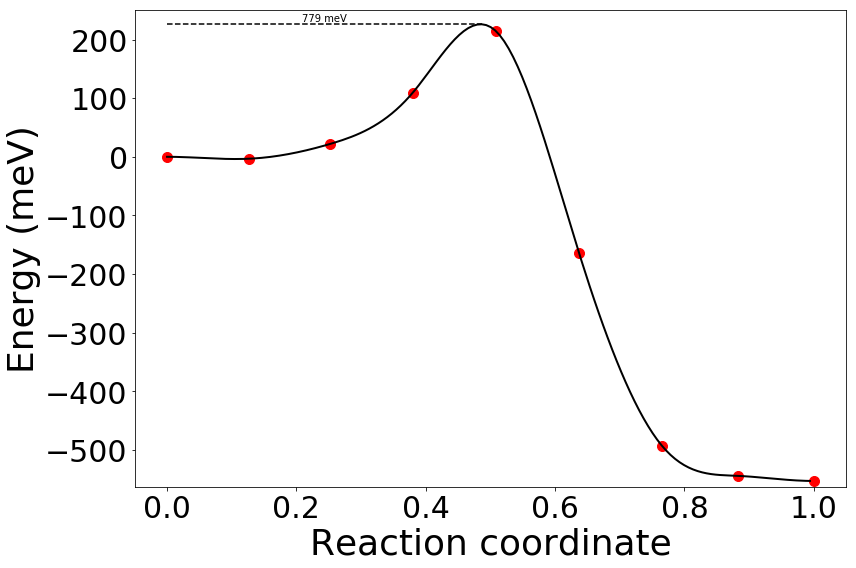

In [29]:
neb_80_49.get_plot().show()

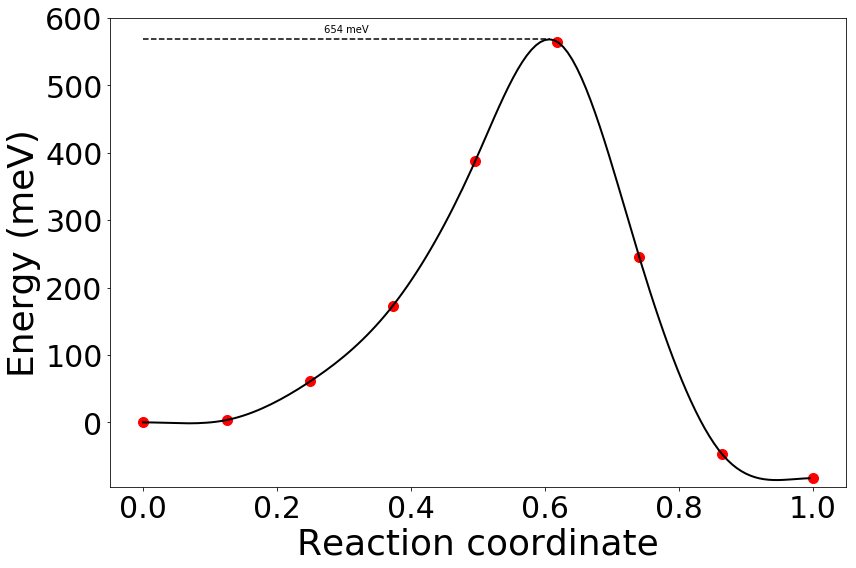

In [30]:
neb_48_92.get_plot().show()

## Various
### Figure help

This is just a place where I can do some tests to see which dimers correspond to which for the figures.

In [78]:
dimer_search_1 = (74, 92)
dimer_search_2 = (64, 56)

for list in dimer_lists:
    if dimer_search_1 in list:
        equivalent_dimer = list[0]
        print("Found requested dimer 1 in list of " + str(equivalent_dimer))
    if dimer_search_2 in list:
        equivalent_dimer = list[0]
        print("Found requested dimer 2 in list of " + str(equivalent_dimer))

# Let's check it
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
symmops = SpacegroupAnalyzer(cat).get_space_group_operations()
symmops.are_symmetrically_equivalent(
    [cat.sites[index] for index in dimer_search_1],
    [cat.sites[index] for index in dimer_search_2]
)

Found requested dimer 1 in list of (64, 54)
Found requested dimer 2 in list of (64, 54)


True